# Clustering para simplificar el modelo

In [8]:
import osmnx as ox
import networkx as nx 
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pickle
import pandas as pd

In [2]:
with open('Mapa_OSMNX.pickle', 'rb') as handle:
    graph = pickle.load(handle)

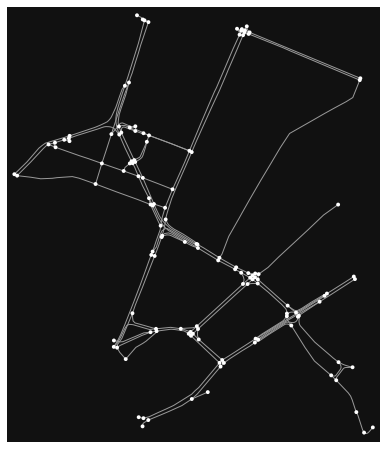

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [3]:
ox.plot_graph(graph)

Se establece el número de centros para poder realizar el clustering.

In [4]:
num_clusters = 35

Se obtienen las posiciones de los nodos para realizar el clustering. Estos datos se almacenan en un dataframe.

In [11]:
#nombres de los nodos
g_nodes = list(graph.nodes)
#posiciones de los nodos
positions_x = nx.get_node_attributes(graph,'x')
positions_y = nx.get_node_attributes(graph,'y')
#creación del dataframe a partir de un diccionario
positions_for_data={'nodos':g_nodes,
    'position_x':positions_x.values(),
    'position_y':positions_y.values()}
data = pd.DataFrame.from_dict(positions_for_data)

In [10]:
data.head()

,nodos,position_x,position_y
0,264268562,-78.500598,-0.202221
1,264268564,-78.500014,-0.202610
2,264268569,-78.498284,-0.203269
3,264270346,-78.490999,-0.200246
4,264270354,-78.490973,-0.200167


Se utiliza MinMaxScaler para normalizar los valores de las columnas.

In [16]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['position_x','position_y']])
data_scaled = pd.DataFrame(data_scaled, columns=data.columns[1:])

In [17]:
data_scaled.head()

,position_x,position_y
0,0.337477,0.733994
1,0.375606,0.712202
2,0.488407,0.675279
3,0.963587,0.844634
4,0.965237,0.849082


Se obtienen los centros con la función de `AgglomerativeClustering`. Se utiliza afinidad euclidiana y se envía el número de centros como parámetro. 

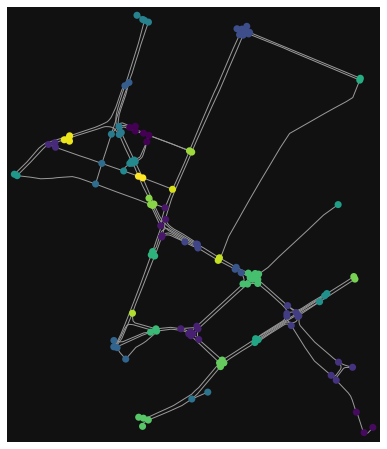

In [19]:
cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')  
colors_num = cluster.fit_predict(data_scaled)

fig, ax = ox.plot_graph(graph,
    node_color=colors_num,
    node_size=50)

plt.show()



El resultado del clustering es una lista de números en el orden de los nodos que representan el grupo al que pertenecen.

In [20]:
colors_num

array([ 0,  0, 29, 21, 21, 13, 14, 12, 12,  4,  3, 26, 26, 26,  3,  3,  3,
       32,  2,  2, 31,  9, 24, 24, 24, 16, 16, 16, 14, 28,  2, 31, 14, 34,
       28, 17, 34, 17, 20,  6, 17, 14, 10, 15, 15, 18, 33, 30, 23, 23, 11,
       11, 11, 26, 13,  7, 22,  5,  5, 25,  6, 18, 29, 11, 15,  5,  5, 24,
        3, 20, 24,  9, 24, 24, 24, 24, 24, 24,  3, 25, 27,  1,  9,  0, 16,
       16, 16,  2,  7,  7, 33, 33, 33,  8,  8,  8,  8,  8,  8,  0,  0,  8,
        8,  8,  8, 27, 15,  0,  4,  4, 28, 28, 19,  3,  3, 20, 25, 25,  1,
        1,  6,  6,  7, 23, 22, 22,  2, 10,  6,  6,  6], dtype=int64)

Todos los nodos que pertenezcan al mismo cluster forman un grupo y hay que sacar el centro de los puntos que conforman el mismo grupo.

Se agregan dos columnas al dataset de los puntos para poder colocar el valor de los centros geográficos.

In [22]:
data['centro_x'] = 0

In [23]:
data['centro_y'] = 0

In [25]:
data.head()

,nodos,position_x,position_y,centro_x,centro_y
0,264268562,-78.500598,-0.202221,0,0
1,264268564,-78.500014,-0.202610,0,0
2,264268569,-78.498284,-0.203269,0,0
3,264270346,-78.490999,-0.200246,0,0
4,264270354,-78.490973,-0.200167,0,0


Se agrega una columna para el grupo al que pertenecen.

In [28]:
data['cluster'] = colors_num

In [29]:
data.head()

,nodos,position_x,position_y,centro_x,centro_y,cluster
0,264268562,-78.500598,-0.202221,0,0,0
1,264268564,-78.500014,-0.202610,0,0,0
2,264268569,-78.498284,-0.203269,0,0,29
3,264270346,-78.490999,-0.200246,0,0,21
4,264270354,-78.490973,-0.200167,0,0,21


Se realiza un `for` que recorrerá el número de grupos que existen para determinar los centros. Se buscan todos los nodos que pertenecen al mismo grupo y se calcula su centro con la función `mean()`. Finalmente, estos datos se agregan al dataset.

In [30]:
centros = []
for cluster in range(max(colors_num)+1):
    indices = np.where(data['cluster']==cluster)
    grupo = data.iloc[indices]
    centro_x = grupo['position_x'].mean()
    centro_y = grupo['position_y'].mean()
    for indice in indices:
        data.at[indice,'centro_x']=centro_x
        data.at[indice,'centro_y']=centro_y
    #estos centros son tuplas
    centros.append((centro_x,centro_y))
        

In [31]:
data.head()

,nodos,position_x,position_y,centro_x,centro_y,cluster
0,264268562,-78.500598,-0.202221,-78.500401,-0.202488,0
1,264268564,-78.500014,-0.202610,-78.500401,-0.202488,0
2,264268569,-78.498284,-0.203269,-78.498235,-0.203297,29
3,264270346,-78.490999,-0.200246,-78.490986,-0.200207,21
4,264270354,-78.490973,-0.200167,-78.490986,-0.200207,21


## Agregar los centros al mapa

Ahora que se han calculado los centros, se pueden pintar sobre el mapa de osmnx. Ya que los nombres de los nodos son una serie de números, se utiliza el número siguiente para nombrar los centros.

In [33]:
inicio_nodos = max(g_nodes)+1

Se agregan los centros al grafo gracias a la lista `centros` declarada arriba. 


In [39]:
centros[:10]

[(-78.50040125, -0.20248826666666667),
 (-78.49079993333334, -0.21495733333333333),
 (-78.49941296, -0.20644891999999998),
 (-78.4981667125, -0.21103442500000003),
 (-78.50411983333333, -0.20301313333333335),
 (-78.491860325, -0.2126993),
 (-78.49388817142858, -0.21029951428571433),
 (-78.498081775, -0.20728062500000002),
 (-78.49596283, -0.19816061999999998),
 (-78.49622876666668, -0.2083583)]

In [34]:
idx = inicio_nodos
colores_centros = []
for centro in centros:
    graph.add_node(idx)
    graph.nodes[idx]['x']=centro[0]
    graph.nodes[idx]['y']=centro[1]
    colores_centros.append(40)
    idx+=1

Se agrega el color de los centros al color de los grupos.

In [35]:
colors_num_2 = np.append(colors_num,colores_centros)

Cada punto amarillo representa un centro obtenido al sacar la media entre los puntos que conforman cada grupo.

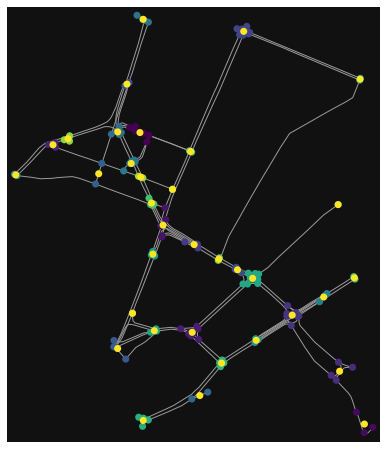

In [37]:
fig, ax = ox.plot_graph(graph,
    node_color=colors_num_2,
    node_size=50)

## Eliminar las calles dentro del mismo grupo

Una vez encontrados los centros, es momento de eliminar las calles que pertencen al mismo grupo, pues en el grafo final, el grupo representa un único nodo.

In [40]:
edges = list(graph.edges())

Se obtienen todas las calles que hay en el grafo.

In [42]:
edges[:10]

[(264268564, 3069687543),
 (264268564, 264268569),
 (264268564, 4207542600),
 (264268569, 850445058),
 (264268569, 267939607),
 (264268569, 264268564),
 (264270346, 264270354),
 (264270346, 267939758),
 (264270354, 264270346),
 (264270354, 3726280025)]

Se elabora una condicional para conocer si dos nodos pertenecen al mismo grupo.

In [45]:
nodo1, nodo2 = 264270354,264270354

In [46]:
if (int(data['cluster'][np.where(data['nodos']==nodo1)[0]]) == 
  int(data['cluster'][np.where(data['nodos']==nodo2)[0]])):
    print('Hello')

Hello


Esta condicional se aplica sobre todas las calles y las calles que pertenecen al mismo grupo son eliminadas.

In [48]:
for nodo1,nodo2 in edges:
    if (int(data['cluster'][np.where(data['nodos']==nodo1)[0]]) == 
      int(data['cluster'][np.where(data['nodos']==nodo2)[0]])):
        #se quitan las calles del mismo grupo
        graph.remove_edge(nodo1,nodo2)

Se compara la cantidad de calles antes y después de este filtro.

In [49]:
len(edges)

200

In [50]:
len(graph.edges)

90

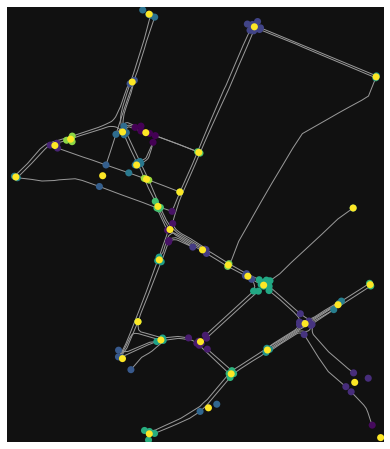

In [51]:
fig, ax = ox.plot_graph(graph,
    node_color=colors_num_2,    
    node_size=50)

Se guarda este nuevo modelo con calles extraídas y centros obtenidos.

In [52]:
a = graph
with open('Cluster_map.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
colors_d = {'colors':colors_num_2}
color_dataset = pd.DataFrame(colors_d)

In [62]:
color_dataset

,colors
0,0
1,0
2,29
3,21
4,21
...,...
161,40
162,40
163,40
164,40


In [63]:
color_dataset.to_csv(r'colores_mapa.csv')

In [64]:
data.head()

,nodos,position_x,position_y,centro_x,centro_y,cluster
0,264268562,-78.500598,-0.202221,-78.500401,-0.202488,0
1,264268564,-78.500014,-0.202610,-78.500401,-0.202488,0
2,264268569,-78.498284,-0.203269,-78.498235,-0.203297,29
3,264270346,-78.490999,-0.200246,-78.490986,-0.200207,21
4,264270354,-78.490973,-0.200167,-78.490986,-0.200207,21


In [65]:
data.to_csv(r'nodos_dataset.csv')

Se decide guardar la posición de los centros, principalmente para poder realizar gráficas con networkx.

In [ ]:
a = centros
with open('Cluster_map.pickle', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)